# Bring-your-own rotated and/or curved domain 

This example is forced by GLORYS, ERA5 reanalysis datasets, and TPXO tidal model

**Note**: FRE-NC tools are required to be set up, as outlined in the [documentation](https://regional-mom6.readthedocs.io/en/latest/) of regional-mom6 package. You will also need to ensure that `matplotlib` is installed in your environment. If it's not, you can add a new cell and evaluate `!pip install matplotlib`.
For this example we need:

- [GEBCO bathymetry](https://www.gebco.net/data_and_products/gridded_bathymetry_data/)
- [GLORYS ocean reanalysis data](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description), and
- [ERA5 surface forcing](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5)
- [TPXO tidal model](https://www.tpxo.net/global)

The example loads the entire ERA5, GEBCO, and TPXO datasets over the whole globe; no need to worry about cutting it down to size.

This example requires you to bring your own MOM6-compatible domain input in netCDF file named `hgrid.nc`. The regional-mom6 package can handle regular, rotated, and curvilinear model domains.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import regional_mom6 as rmom6

import os
from pathlib import Path
from dask.distributed import Client

client = Client()
client

# Currently, only the regional_mom6 module reports logging information to the info level, for more detailed output, uncomment the following:
# import logging
# logging.basicConfig(level=logging.INFO) 

## Step 1: Choose our domain, define workspace paths

To make sure that things are working we recommend starting with a small domain. If that seems OK, then users can change to the domain of their choice and, hopefully, that runs OK too! You can always check the [README](https://github.com/COSIMA/regional-mom6/blob/main/README.md) and [documentation](https://regional-mom6.readthedocs.io/) for troubleshooting tips.

In [ ]:
expt_name = "rotated-demo"

date_range = ["2003-01-01 00:00:00", "2003-01-05 00:00:00"]

## Place where all your input files go 
input_dir = Path(f"mom6_input_directories/{expt_name}/")

## Directory where you'll run the experiment from
run_dir = Path(f"mom6_run_directories/{expt_name}/")

## Directory where compiled FRE tools are located (needed for construction of mask tables)
fre_tools_dir = Path("PATH_TO_FRE_TOOLS")

## Path to where your raw ocean forcing files are stored
glorys_path = Path(f"PATH_TO_GLORYS_DATA" )

## Directory where the ERA raw atmospheric output files are stored
era_path = Path("PATH_TO_ERA5_DATA/era5/single-levels/reanalysis")

## Location of TPXO raw tidal file
## Note: users need to swap the ## in the filenames to the version number of the TPXO input files
tide_h_path = Path("PATH_TO_TPXO_H_FILE/h_tpxo##.nc")
tide_u_path = Path("PATH_TO_TPXO_U_FILE/u_tpxo##.nc")

## Location of the bring-your-own hgrid file
byogrid_path = "PATH_TO_YOUR_HORIZONTAL_GRID/small_curvilinear_hgrid.nc"

## Location where the bathymetry data is stored
bathymetry_path = Path("PATH_TO_GEBCO_FILE/GEBCO_2022.nc")

## if directories don't exist, create them
for path in (run_dir, glorys_path, input_dir):
    os.makedirs(str(path), exist_ok=True)

## Copy hgrid.nc into the experinment folder
import shutil
shutil.copy2(byogrid_path, input_dir/"hgrid.nc")

## Step 2: Make experiment object
The `regional_mom6.experiment` contains the regional domain basics, and also generates the horizontal and vertical grids, `hgrid` and `vgrid` respectively, and sets up the directory structures. 

In [ ]:
expt = rmom6.experiment(
    date_range = date_range,
    resolution = 0.5,
    number_vertical_layers = 75,
    layer_thickness_ratio = 100,
    depth = 4500,
    minimum_depth = 5,
    mom_run_dir = run_dir,
    mom_input_dir = input_dir,
    fre_tools_dir = fre_tools_dir,
    hgrid_type = 'from_file',
    boundaries = ['north', 'south', 'east', 'west']
)

## Step 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `mom6-regional` package that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

This bash script uses the [Copernicus marine toolbox]( https://help.marine.copernicus.eu/en/articles/7970514-copernicus-marine-toolbox-installation) and users should install this before running the bash script.


In [ ]:
expt.get_glorys(
    raw_boundaries_path=glorys_path
)

## Step 4: Set up bathymetry

Similarly to ocean forcing, we point the experiment's `setup_bathymetry` method at the location of the file of choice and also provide the variable names. We don't need to preprocess the bathymetry since it is simply a two-dimensional field and is easier to deal with. Afterwards you can inspect `expt.bathymetry` to have a look at the regional domain.

After running this cell, your input directory will contain other bathymetry-related things like the ocean mosaic and mask table too. The mask table defaults to a 10x10 layout and can be modified later.

In [ ]:
expt.setup_bathymetry(
    bathymetry_path=bathymetry_path,
    longitude_coordinate_name="lon",
    latitude_coordinate_name="lat",
    vertical_coordinate_name="elevation",
)

### Check out your domain: 
The `expt.bathymetry` method returns an xarray dataset, which can be plotted as usual. If the user hasn't yet run `setup_bathymetry`, then calling `expt.bathymetry` will return `None` and prompt them to do so!

Here we plot two plots: the first is in $x$-$y$ coordinates and looks rectangular. The second is in latitude-longitude coordinates and shows the shape of the curvilinear/rotated domain.

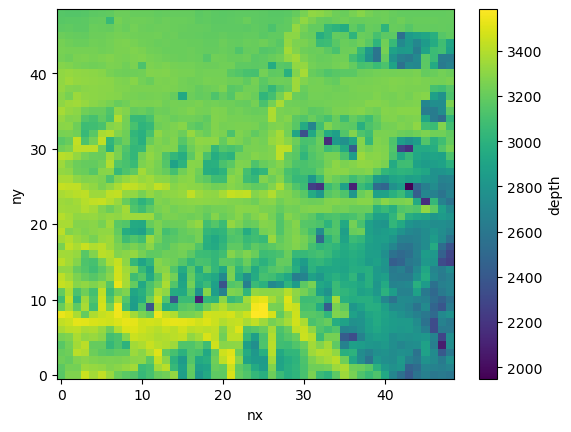

In [6]:
# Note this is x/y rather than lat/lon coordinates
expt.bathymetry.depth.plot()

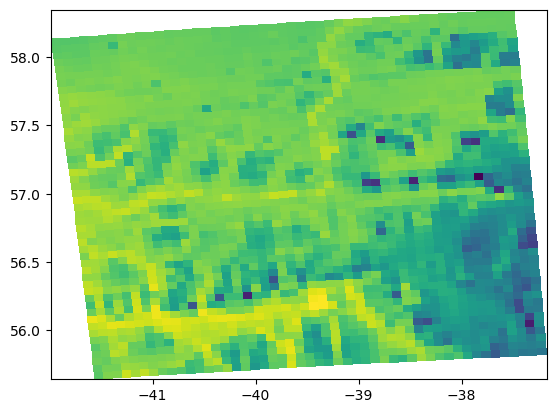

In [9]:
#In lat/lon coords
from regional_mom6 import regridding
import matplotlib.pyplot as plt
import xarray as xr

bathymetry = xr.open_dataset(input_dir/"bathymetry.nc")
hgrid = xr.open_dataset(input_dir/"hgrid.nc")

t_points = regridding.get_hgrid_arakawa_c_points(hgrid, point_type = "t")

plt.pcolormesh(t_points.tlon, t_points.tlat, bathymetry.isel(ntiles=0).depth)

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how for GLORYS, the horizontal dimensions are `latitude` and `longitude`, vs `xh`, `yh`, `xq`, `yq` for MOM6. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations.

In [ ]:
# Define a mapping from the GLORYS variables and dimensions to the MOM6 ones
ocean_varnames = {"time": "time",
                  "yh": "latitude",
                  "xh": "longitude",
                  "zl": "depth",
                  "eta": "zos",
                  "u": "uo",
                  "v": "vo",
                  "tracers": {"salt": "so", "temp": "thetao"}
                  }

# Set up the initial condition
expt.setup_initial_condition(
    glorys_path / "ic_unprocessed.nc", # directory where the unprocessed initial condition is stored, as defined earlier
    ocean_varnames,
    arakawa_grid="A"
    )    

# Set up the four boundary conditions. Remember that in the glorys_path, we have four boundary files names north_unprocessed.nc etc. 
expt.setup_ocean_state_boundaries(
        glorys_path,
        ocean_varnames,
        arakawa_grid = "A"
        )

### Check out your initial condition data

Text(0.5, 1.0, 'lon/lat coords')

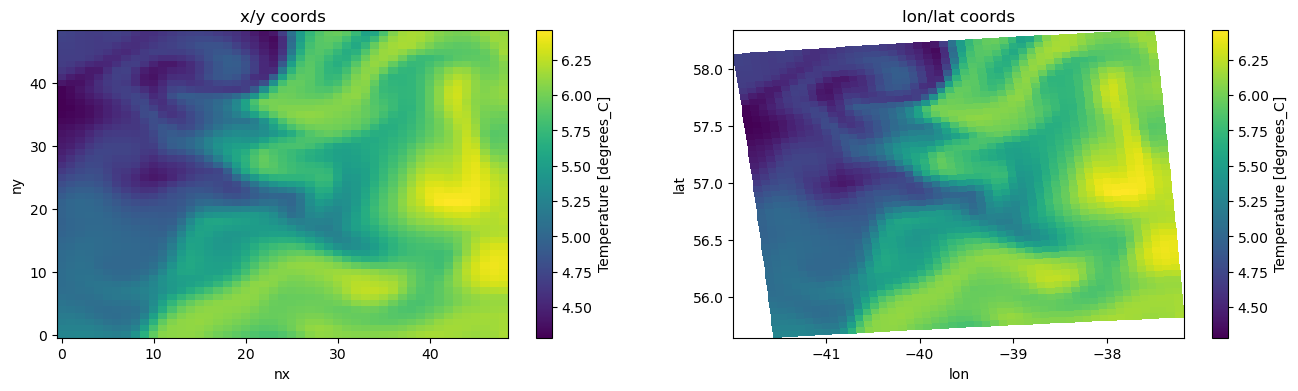

In [11]:
## Preview the initial temperature at the surface in x/y and lat/lon coordinates
from matplotlib import pyplot as plt

## Create a new temperature array with lat and lon coords
templatlon = expt.init_tracers.temp.assign_coords(lon=bathymetry.lon, lat=bathymetry.lat)

#plotting
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

templatlon.isel(zl=0).plot(ax=axes[0])
templatlon.isel(zl=0).plot(x="lon", y="lat", ax=axes[1])
axes[0].set_title("x/y coords")
axes[1].set_title("lon/lat coords")

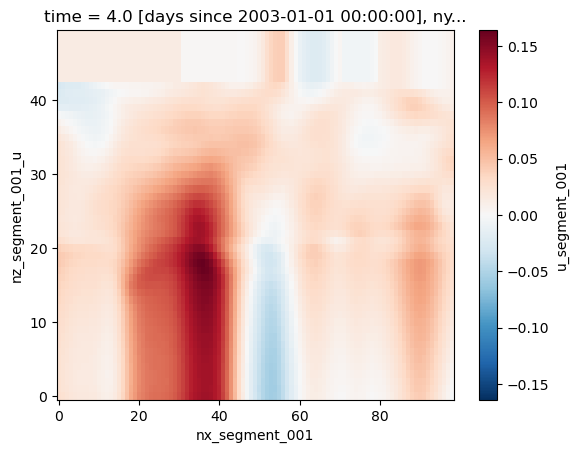

In [13]:
## u boundary forcing for segment 1 (south)
expt.segment_001.u_segment_001.isel(time = 4).plot()

### Step 6: Create Tidal forcing
Note that this step can take a while (like 5min or so). 

In [ ]:
# If you have downloaded the TPXO tidal data and wish to include tidal forcing at the boundary, run this cell
expt.setup_boundary_tides(
        tide_h_path,
        tide_u_path,
        tidal_constituents=["M2"],
)

## Step 7: Run the FRE tools

This is just a wrapper for the FRE tools needed to make the mosaics and masks for the experiment. The only thing you need to tell it is the processor layout. In this case we're saying that we want a 10 by 10 grid of 100 processors. 

In [ ]:
expt.run_FRE_tools(layout=(10, 10)) ##the tiling/no processors

## Step 8: Set up ERA5 forcing:

Here we assume the ERA5 dataset is stored somewhere on the system we are working on. 

Below is a table showing ERA5 characteristics and what needs to be done to sort it out.

**Required ERA5 data**:

Name | ERA5 filename | ERA5 variable name | Units
---|---|---|---
Surface Pressure | sp | sp | Pa 
Surface Temperature | 2t | t2m | K 
Meridional Wind | 10v | v10 | m/s 
Zonal Wind | 10u | u10 | m/s 
Specific Humidity | - | - | kg/kg, calculated from dewpoint temperature
Dewpoint Temperature | 2d | d2m | K


We calculate specific humidity $q$ from dewpoint temperature $T_d$ and surface pressure $P$ via saturation vapour pressure $P_v$.

$$P_v = 10^{8.07131 - \frac{1730.63}{233.426 + T}} \frac{101325}{760} \; \textrm{[Pascal]} $$

$$q = 0.001 \times 0.622  \frac{P_v}{P}$$

In [ ]:
expt.setup_era5(era_path)

## Step 8: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This step copies the default directory and modifies the `MOM_layout` files to match your experiment by inserting the right number of x, y points and CPU layout.

To run MOM6 using the [payu infrastructure](https://github.com/payu-org/payu), provide the keyword argument `using_payu = True` to the `setup_run_directory` method. Doing so, an example `config.yaml` file is generated in the run directory. The `config.yaml` file needs to be modified manually to add the locations of executables, etc.

In [ ]:
expt.setup_run_directory(surface_forcing = "era5", with_tides = False)
# To turn on tides (assuming you ran step 6), set `with_tides = True`